In [1]:
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [14]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)

def magnitude(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b)

def Normalize(data_set):
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    
    y = lambda x, mn, mx: (x - mn) / (mx - mn)
    return xr.apply_ufunc(y, data_set, mn, mx, dask='allowed')


def Re_arrange(data_set, years):
    g = []
    n = []
    r = []

    for i,y in enumerate(years):
        aa = data_set.sel(time=data_set['year']==y).resample(time='W').mean()
        aa = aa.groupby('time.week').mean(dim='time')

        if aa.shape[0] != 53:
            aa = xr.concat([aa,zero], dim='week')
        
        aa = aa.stack(map=('longitude', 'latitude'))
        aa = aa.dropna(dim='map', how='any')
        nn  = aa.groupby('map').apply(Normalize)
        nr = nn.groupby('map').apply(Rolled)
        
        g.append(aa)
        n.append(nn)
        r.append(nr)
        print(y)

    return(g, n, r)


def Rolled(data_set):
    min_w = data_set.argmin(dim='week', skipna=True).values
    rol = np.roll(data_set, -min_w, axis=0)
    
    return rol

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################
dir_1 = '../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_of = '/home/lgarcia/Documents/Other_datasets/'
dir_oi = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [5]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [6]:
coord = 'gul'
region = Crops(coord, c_armor1, reg_ext)
region2 = Crops(coord, c_armor15, reg_ext)

region2 = Masking(region2, region2.to[0,25])

In [7]:
points = region.mlotst[:,::8,::8].where(region2.mask==1)
print(points.latitude.size, points.longitude.size)

8 15


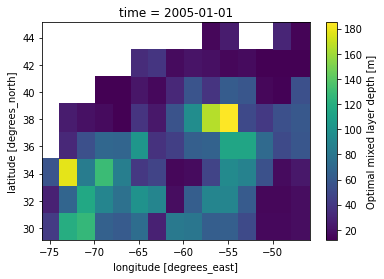

In [9]:
points[0].plot()

In [10]:
pp = points.time.dt.year
points.coords['year'] = (('time'), pp)

In [11]:
la = points.latitude.values.size
lo = points.longitude.values.size
valslo = points.longitude.values
valsla = points.latitude.values

zero = xr.DataArray(np.zeros((1, la, lo)), 
                    dims=["week", "latitude", "longitude"], 
                          coords={"week": [53],
                                  "latitude": valsla,
                                  "longitude": valslo},
                    name='mlotst')

## Re-shaing the dataset

It  is done in two groups. The analysis ignores the 2018 because is not complete and the 2010, because it causes problems with the dimensions. Why? I still do not know.

The shift is done to put the minimum at the first time step.

In [12]:
## Exclude 2018 because is not a full year
## Also excluding 2010, because it makes problem with the dimensions 'week'
years1 = [y for y in range(2005, 2010)]
years2 = [y for y in range(2011, 2018)]

In [ ]:
## Reshaping, normalizing and shifting
week1, norm1, roll1 = Re_arrange(points, years1)
week2, norm2, roll2 = Re_arrange(points, years2)

2005
2006


In [ ]:
## Concatenating the data arrays
new_p1 = xr.concat(week1, dim='map')
new_p2 = xr.concat(week2, dim='map')

nor_p1 = xr.concat(norm1, dim='map')
nor_p2 = xr.concat(norm2, dim='map')

rol_p1 = xr.concat(roll1, dim='map')
rol_p2 = xr.concat(roll2, dim='map')

In [ ]:
## Big data arrays, with all the years and grid points
new_points = xr.concat([new_p1,new_p2], dim='map')
nor_points = xr.concat([nor_p1,nor_p2], dim='map')
rol_points = xr.concat([rol_p1,rol_p2], dim='map')

In [ ]:
## Change of the map=(lon,lat) -> map=(point).
## Now 'map' is uni-index.

new_points = new_points.reset_index(dims_or_levels='map')
nor_points = nor_points.reset_index(dims_or_levels='map')
rol_points = rol_points.reset_index(dims_or_levels='map')

In [ ]:
new_points.T.plot()

In [ ]:
nor_points.T.plot()

In [ ]:
rol_points.T.plot()

Maaaaaaaaaaaaay be now, apply PCA

This is a try with the arrays shifted, starting from minimum value

In [ ]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)
pca.fit(ds)

In [ ]:
print(pca.singular_values_)

In [ ]:
## 53x12
reduced_values = pca.transform(ds)

In [ ]:
reduced_values[0]

In [ ]:
## 53x12
print(pca.components_.size)

In [ ]:
ds

In [ ]:
eigenvalues = pca.components_
reduced_data = reduced_values
expl_variance = pca.explained_variance_ratio_*100

print(eigenvalues.shape, reduced_data.shape, expl_variance.shape)

In [ ]:
plt.plot(eigenvalues[0])
plt.show()

In [ ]:
plt.plot(eigenvalues[1])
plt.show()

In [ ]:
plt.plot(eigenvalues[2])
plt.show()

In [ ]:
plt.plot(eigenvalues[3])
plt.show()

This is a try with the normalized data, but any shift

In [ ]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)
pca.fit(rolled)

In [ ]:
print(pca.singular_values_)

In [ ]:
## 53x12
reduced_values = pca.transform(ds)

In [ ]:
reduced_values[0]

In [ ]:
## 53x12
print(pca.components_.size)

In [ ]:
ds

In [ ]:
eigenvalues = pca.components_
reduced_data = reduced_values
expl_variance = pca.explained_variance_ratio_*100

print(eigenvalues.shape, reduced_data.shape, expl_variance.shape)

In [ ]:
plt.plot(eigenvalues[0])
plt.show()

In [ ]:
plt.plot(eigenvalues[1])
plt.show()

In [ ]:
plt.plot(eigenvalues[2])
plt.show()

In [ ]:
plt.plot(eigenvalues[3])
plt.show()

In [ ]:
for i in range(12):
    name = 'PCA' + str(i)
    plt.plot(eigenvalues[i])
    plt.label(name)

plt.legend()
plt.show()

In [ ]:
ds['explained_variance'].plot(label='exp.var. alone')
ds['explained_variance'].cumsum(dim='n_eof').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

For example PC1

In [ ]:
PC = eigenvalues.dot(ds.T)
PC

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,5), 
                       sharex=True, sharey=True, constrained_layout=True)
for i in range(4):
    for j in range(4):
        print(i,j)

        x = PC[i]
        y = PC[j]
        name = 'PC' + str(i) + '-' + str(j)

        ax[i,j].scatter(x, y)
        ax[i,j].set_ylabel(name)

plt.show()